# Imports

In [58]:

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


# Load datasets

In [59]:
X_train_estimated_a = pd.read_parquet('../data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../data/C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../data/C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../data/C/X_test_estimated.parquet')

train_targets_a = pd.read_parquet('../data/A/train_targets.parquet')
train_targets_b = pd.read_parquet('../data/B/train_targets.parquet')
train_targets_c = pd.read_parquet('../data/C/train_targets.parquet')

# Data clean up

In [60]:

# Data set A, B and C clean up

def data_clean_up(x_train_est, x_train_observe, y_train):

  if 'date_calc' in x_train_est.columns:
    x_train_est.drop(columns="date_calc", inplace=True)

  x_train = pd.concat([x_train_observe, x_train_est])

  # Group the rows into blocks of 4 and apply the aggregation function
  agg_func = {col: 'mean' for col in x_train.columns[1:]}
  X_train_downscaled = x_train.groupby(x_train.index // 4).agg({**{'date_forecast': 'first'}, **agg_func})

  y_train.dropna(inplace=True)
  combined_data = pd.merge(X_train_downscaled, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'date_forecast' and 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns="date_forecast", inplace=True)
    combined_data.drop(columns="time", inplace=True)
    combined_data.drop(columns="pv_measurement", inplace=True)

  return combined_data, y_train

x_train_a, y_train_a = data_clean_up(X_train_estimated_a, X_train_observed_a, train_targets_a)
x_train_b, y_train_b = data_clean_up(X_train_estimated_b, X_train_observed_b, train_targets_b)
x_train_c, y_train_c = data_clean_up(X_train_estimated_c, X_train_observed_c, train_targets_c)

In [61]:

def data_clean_up_test(x_test_est):

  # Group the rows into blocks of 4 and apply the aggregation function
  agg_func = {col: 'mean' for col in x_test_est.columns[1:]}
  X_test_downscaled = x_test_est.groupby(x_test_est.index // 4).agg({**{'date_forecast': 'first'}, **agg_func})

  if 'date_forecast' in X_test_downscaled.columns:
    X_test_downscaled.drop(columns="date_forecast", inplace=True)

  return X_test_downscaled

# Feature engineering

In [62]:
# Do something

# Training the model

In [69]:
# Convert the data to NumPy arrays or Pandas DataFrames
x_train_np_a = x_train_a.to_numpy()
y_train_np_a = y_train_a.to_numpy()

x_train_np_b = x_train_b.to_numpy()
y_train_np_b = y_train_b.to_numpy()

x_train_np_c = x_train_c.to_numpy()
y_train_np_c = y_train_c.to_numpy()


# Split data into training and validation sets
train_size = 0.8

print(x_train_np_a.shape)

x_train_split_a, x_valid_split_a, y_train_split_a, y_valid_split_a = train_test_split(
    x_train_np_a, y_train_np_a, train_size=train_size, random_state=42
)

x_train_split_b, x_valid_split_b, y_train_split_b, y_valid_split_b = train_test_split(
    x_train_np_b, y_train_np_b, train_size=train_size, random_state=42
)

x_train_split_c, x_valid_split_c, y_train_split_c, y_valid_split_c = train_test_split(
    x_train_np_c, y_train_np_c, train_size=train_size, random_state=42
)


# Create LightGBM datasets
train_data_a = lgb.Dataset(x_train_split_a, label=y_train_split_a)
valid_data_a = lgb.Dataset(x_valid_split_a, label=y_valid_split_a, reference=train_data_a)


train_data_b = lgb.Dataset(x_train_split_b, label=y_train_split_b)
valid_data_b = lgb.Dataset(x_valid_split_b, label=y_valid_split_b, reference=train_data_b)

train_data_c = lgb.Dataset(x_train_split_c, label=y_train_split_c)
valid_data_c = lgb.Dataset(x_valid_split_c, label=y_valid_split_c, reference=train_data_b)




(29667, 45)


In [64]:

# Define hyperparameters
params = {
    'objective': 'regression',
    'metric': 'rmse',  # Use an appropriate metric for your problem
    # Add other hyperparameters here
}


# Train the model
num_round = 10000  # You can adjust the number of boosting rounds
model_a = lgb.train(
    params,
    train_data_a,
    num_round,
    valid_sets=[valid_data_a]
)

model_b = lgb.train(
    params,
    train_data_b,
    num_round,
    valid_sets=[valid_data_b]
)

model_c = lgb.train(
    params,
    train_data_c,
    num_round,
    valid_sets=[valid_data_c]
)


# Make predictions
# Do some more stuff


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7913
[LightGBM] [Info] Number of data points in the train set: 23733, number of used features: 42
[LightGBM] [Info] Start training from score 680.011495
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7942
[LightGBM] [Info] Number of data points in the train set: 23374, number of used features: 42
[LightGBM] [Info] Start training from score 102.697315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

# Make predictions

In [65]:
# Do some more stuff

X_test_estimated_a = data_clean_up_test(X_test_estimated_a)
X_test_estimated_b = data_clean_up_test(X_test_estimated_b)
X_test_estimated_c = data_clean_up_test(X_test_estimated_c)

y_test_pred_a = model_a.predict(X_test_estimated_a)
y_test_pred_b = model_b.predict(X_test_estimated_b)
y_test_pred_c = model_c.predict(X_test_estimated_c)

print(y_test_pred_a)

y_pred = np.concatenate((y_test_pred_a, y_test_pred_b, y_test_pred_c), axis=0)


[-7.54435202e+00 -2.79928625e+00  2.85665646e+00  4.27446672e+01
  2.98222313e+02  8.53209990e+02  1.83247030e+03  2.80373116e+03
  2.41159455e+03  1.96950261e+03  2.39948656e+03  2.28271063e+03
  2.14743238e+03  1.89343647e+03  2.29033664e+03  1.74304022e+03
  1.17154120e+03  4.54966103e+02  2.15838043e+02  2.19388060e+01
  5.15723851e+00  2.26743587e+00 -3.23433364e+00  1.51961160e+01
 -4.78261002e+00 -1.97717918e+01  1.18159566e+01  2.14083162e+02
  8.23216020e+02  1.34185658e+03  2.06150644e+03  3.19738438e+03
  3.76241388e+03  3.95506703e+03  3.79392230e+03  3.34603434e+03
  3.29928783e+03  3.97730328e+03  3.45452983e+03  2.69829463e+03
  1.51082324e+03  7.28905707e+02  2.91282718e+02  1.36894977e+02
  7.28702450e+01  3.33193047e+01 -1.73095407e+01  2.74993054e+01
  3.88108354e+01  2.59793658e+01  5.84406658e+01  2.76518116e+02
  7.14122774e+02  1.23666448e+03  2.94483827e+03  3.57404013e+03
  4.24460431e+03  4.85820075e+03  4.80138039e+03  4.20597630e+03
  4.60826476e+03  4.23568

# Evaluate prediction

In [66]:
# Evaluate the model


valid_pred = model_a.predict(x_valid_split_a)

rmse = np.sqrt(mean_squared_error(y_valid_split_a, valid_pred))
print(f'RMSE: {rmse}')


RMSE: 390.87232784835953


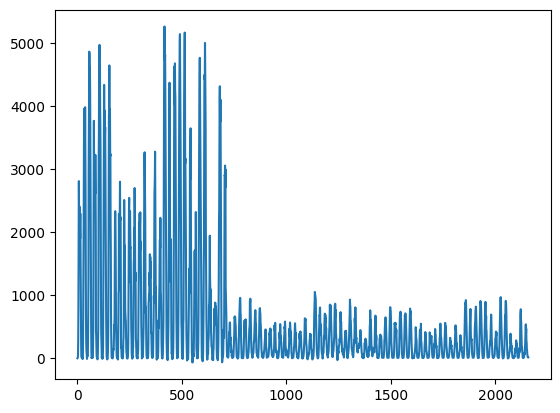

In [67]:
plt.plot(y_pred, label='true')

# Create submission

In [68]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submission.csv', index=False)